In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def embeddings(image):
    img1 = Image.open(image)
    img1 = img1.resize((160, 160))
    face_pixels = np.array(img1)
    face_pixels = face_pixels.astype('float32')
    mean = face_pixels.mean()
    std = face_pixels.std()
    face_pixels = (face_pixels - mean) / (std + (1e-07))
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

In [3]:
from os import listdir

def load_faces(directory):
    faces = []
    
    for filename in listdir(directory):
        path = directory + filename
        face = embeddings(path)
        faces.append(face)
    
    return faces

In [4]:
def load_dataset(directory):
    x, y = [], []
    i = 1
    
    for subdir in tqdm(listdir(directory)):
        path = directory + subdir + '/'
        faces = load_faces(path)
        labels = [subdir for _ in range(len(faces))]
        print('%d There are %d images in the class %s:'%(i, len(faces), subdir))
        x.extend(faces)
        y.extend(labels)
        i = i + 1
        
    return np.array(x), np.array(y)

In [5]:
from tensorflow.keras.models import load_model

model = load_model(r'../input/facenet-keras/facenet_keras.h5')

embd_img, flabels = load_dataset(r'../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/')
print(embd_img.shape, flabels.shape)

embd_img_valid, flabels_valid = load_dataset(r'../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/')
print(embd_img_valid.shape, flabels_valid.shape)

np.savez_compressed(r'./FaceDatasetTrain.npz', embd_img, flabels)
np.savez_compressed(r'./FaceDatasetValid.npz', embd_img_valid, flabels_valid)

2022-12-03 15:51:15.028079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 15:51:15.135985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 15:51:15.136857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 15:51:15.138935: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

1 There are 5000 images in the class WithoutMask:


100%|██████████| 2/2 [09:50<00:00, 295.32s/it]


2 There are 5000 images in the class WithMask:
(10000, 128) (10000,)


 50%|█████     | 1/2 [00:22<00:22, 22.78s/it]

1 There are 400 images in the class WithoutMask:


100%|██████████| 2/2 [00:46<00:00, 23.26s/it]

2 There are 400 images in the class WithMask:
(800, 128) (800,)


In [6]:
data_train = np.load(r'././FaceDatasetTrain.npz')
embd_img, flabels = data_train['arr_0'], data_train['arr_1']

data_valid = np.load(r'././FaceDatasetValid.npz')
embd_img_valid, flabels_valid = data_valid['arr_0'], data_valid['arr_1']

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

in_encode = Normalizer(norm = 'l2')
embd_img = in_encode.fit_transform(embd_img)
embd_img_valid = in_encode.transform(embd_img_valid)

out_encode = LabelEncoder()

flabels2 = out_encode.fit_transform(flabels)
flabels_valid2 = out_encode.transform(flabels_valid)

model2 = SVC(kernel = 'linear', probability = True)
model2.fit(embd_img, flabels2)
predictions = model2.predict(embd_img_valid)

In [8]:
from sklearn.metrics import classification_report

ac = classification_report(predictions, flabels_valid2)
print(ac)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       402
           1       0.93      0.93      0.93       398

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800



Input test embeddings (128,)
['WithMask']


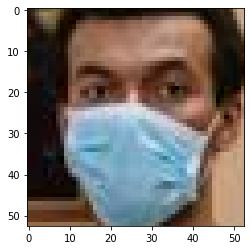

In [9]:
input_image = r'../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1388.png'

imagedisp = Image.open(input_image)

plt.imshow(imagedisp)

embd_test = list()

embd_test = embeddings(input_image)

print('Input test embeddings', embd_test.shape)

k = np.array(embd_test)
k = k.reshape(1, -1)
embd_test = k
embd_test = in_encode.transform(embd_test)

predictions = model2.predict(embd_test)
print(out_encode.inverse_transform(predictions))